In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize
import h5py
import cv2

def viz_data(pressure, pressure_min, pressure_max, use_log):
    pressure = (pressure.astype(np.float32) - pressure_min) / (pressure_max - pressure_min)
    pressure = np.clip(pressure, 0, 1)
    if use_log:
        pressure = np.log(pressure + 1) / np.log(2.0)

    im = cv2.applyColorMap((np.clip(pressure, 0, 1) * 255).astype('uint8'), cv2.COLORMAP_JET)
    im = cv2.resize(im, (pressure.shape[0]*15, pressure.shape[1]*15))
    return im

def tactile_reading(path):
    """
    Reads tactile sensor data from an HDF5 file.

    This function opens an HDF5 file at the specified path and extracts 
    tactile sensor data, including frame count, timestamps, pressure readings, 
    and packet IDs. The data is then returned as numpy arrays.

    Parameters:
    path (str): The path to the HDF5 file containing the tactile sensor data.

    Returns:
    tuple:
        pressure (np.ndarray): An array of pressure readings with shape (frame_count,rows,cols). (32x32 by default)
        frame_count (int): The number of frames (or data points) in the file.
        ts (np.ndarray): An array of timestamps with shape (frame_count,).
        packetIDs (np.ndarray): An array of packet IDs with shape (frame_count,9). Represents all packetIDs received during a frame. 
    """
    f = h5py.File(path, 'r')
    fc = f['frame_count'][0]
    ts = np.array(f['ts'][:fc//2])
    pressure = np.array(f['pressure'][:fc//2]).astype(np.float32)
    packetIDs = np.array(f['packetNumber'][:fc//2])
    return pressure, fc, ts, packetIDs

# Define the prediction function
def predict_value(pressure, frame,y,x, p):
    if frame == 0:
        return pressure[frame,y,x]  # No previous value, use initial value
    return max(0,pressure[frame,y,x] + 1 / (p) * (pressure[frame,y,x] - pressure[frame-1,y,x]))
def copyInto(predPressure,arr,startIdx):
    totalElements = predPressure.size
    end_index = startIdx +len(arr)
    if end_index > totalElements:
        end_index = totalElements
    # Calculate the number of elements that can be copied
    num_elements_to_copy = end_index - startIdx

    # Use numpy.ravel to get a flat view of the 3D array
    flat_array = predPressure.ravel()
    
    # Copy the elements from array_1d to the flat view of the 3D array
    flat_array[startIdx:startIdx + num_elements_to_copy] = arr[:num_elements_to_copy]

def calcMetricsReturnPred(filePath,p,d):
    truePressure = tactile_reading(filePath)[0]
    print(truePressure.shape)
    predPressure = np.zeros(truePressure.shape)
    predPressure[0:2]=truePressure[0:2]
    totalError = 0
    avgError = 0
    lastIndex = truePressure.shape[0]*truePressure.shape[1]*truePressure.shape[2]
    transmitted_data_count = 0
    packetCount = 0
    numNodes = 120
    preds = np.zeros(numNodes)
    trues = np.zeros(numNodes)
    frame = 2
    startIdx = 0
    lastFrameReached = False
    while not lastFrameReached:
        for y in range(truePressure.shape[1]):
            for x in range(truePressure.shape[2]):
                if packetCount==0:
                    startIdx = frame*truePressure.shape[1]*truePressure.shape[2]+truePressure.shape[2]*y+x
    
                pred = predict_value(predPressure,frame-1,y,x,p)
                preds[packetCount] = pred
                trues[packetCount] = truePressure[frame,y,x]
                totalError += abs(pred-truePressure[frame,y,x])
                if packetCount == numNodes-1:
                    avgError = totalError/numNodes
                    if avgError > d:
                        transmitted_data_count+=1
                        copyInto(predPressure,trues,startIdx)
                    else:
                        copyInto(predPressure,preds,startIdx)
                    packetCount = 0
                    totalError = 0
                    preds=np.zeros(numNodes)
                    trues=np.zeros(numNodes)

                else:
                    packetCount +=1
                if frame*truePressure.shape[1]*truePressure.shape[2]+truePressure.shape[2]*y+x == lastIndex -1:
                    lastFrameReached = True
                    break
                if y==truePressure.shape[1]-1 and x==truePressure.shape[2]-1:
                    frame+=1


    # Compute the RMSE
    error = predPressure - truePressure
    mse = np.mean(error ** 2)
    rmse_value = np.sqrt(mse)
    range_y = np.max(truePressure) - np.min(truePressure)
    print(range_y)
    nrmse = rmse_value/range_y
    transmitted_percentage = transmitted_data_count /(lastIndex//numNodes)
    return nrmse, transmitted_percentage, predPressure
    
    
# Calculate the RMSE and the percentage of transmitted data for given values of p and d
def calculate_metrics(filePath, p, d):
    truePressure = tactile_reading(filePath)[0]
    print(truePressure.shape)
    predPressure = np.zeros(truePressure.shape)
    predPressure[0:2]=truePressure[0:2]
    totalError = 0
    avgError = 0
    lastIndex = truePressure.shape[0]*truePressure.shape[1]*truePressure.shape[2]
    transmitted_data_count = 0
    packetCount = 0
    numNodes = 120
    preds = np.zeros(numNodes)
    trues = np.zeros(numNodes)
    frame = 2
    startIdx = 0
    lastFrameReached = False
    while not lastFrameReached:
        for y in range(truePressure.shape[1]):
            for x in range(truePressure.shape[2]):
                if packetCount==0:
                    startIdx = frame*truePressure.shape[1]*truePressure.shape[2]+truePressure.shape[2]*y+x
    
                pred = predict_value(predPressure,frame-1,y,x,p)
                preds[packetCount] = pred
                trues[packetCount] = truePressure[frame,y,x]
                totalError += abs(pred-truePressure[frame,y,x])
                if packetCount == numNodes-1:
                    avgError = totalError/numNodes
                    if avgError > d:
                        transmitted_data_count+=1
                        copyInto(predPressure,trues,startIdx)
                    else:
                        copyInto(predPressure,preds,startIdx)
                    packetCount = 0
                    totalError = 0
                    preds=np.zeros(numNodes)
                    trues=np.zeros(numNodes)

                else:
                    packetCount +=1
                if frame*truePressure.shape[1]*truePressure.shape[2]+truePressure.shape[2]*y+x == lastIndex -1:
                    lastFrameReached = True
                    break
                if y==truePressure.shape[1]-1 and x==truePressure.shape[2]-1:
                    frame+=1


    # Compute the RMSE
    error = predPressure - truePressure
    mse = np.mean(error ** 2)
    rmse_value = np.sqrt(mse)
    range_y = np.max(truePressure) - np.min(truePressure)
    print(range_y)
    nrmse = rmse_value/range_y
    transmitted_percentage = transmitted_data_count /(lastIndex//numNodes)
    return nrmse, transmitted_percentage

# Objective function to minimize with constraint
def objective(params, filePath, alpha=0.5):
    p, d = params
    nrmse, transmitted_percentage = calculate_metrics(filePath, p, d)
    print(nrmse, transmitted_percentage)
    print(alpha * nrmse + (1 - alpha) * transmitted_percentage)
    return alpha * nrmse + (1 - alpha) * transmitted_percentage

# Constraint function for transmission percentage
def constraint(params, filePath, max_transmission_percentage):
    p, d = params
    _, transmitted_percentage = calculate_metrics(filePath, p, d)
    print(transmitted_percentage)
    return max_transmission_percentage - transmitted_percentage

def callback(xk):
    print(f"Current parameters: {xk}")

# Optimization function to find the best p and d with constraint
def optimize_parameters(filePath, p_bounds, d_bounds, max_transmission_percentage, alpha=0.5):
    initial_guess = [(p_bounds[0] + p_bounds[1]) / 2, (d_bounds[0] + d_bounds[1]) / 2]
    cons = ({'type': 'ineq', 'fun': constraint, 'args': (filePath, max_transmission_percentage)})
    result = minimize(objective, initial_guess, args=(filePath, alpha), bounds=[p_bounds, d_bounds], callback=callback,options={"disp":True})
    best_p, best_d = result.x
    best_nrmse, best_transmitted_percentage = calculate_metrics(filePath, best_p, best_d)
    return best_p, best_d, best_nrmse, best_transmitted_percentage

# Generate a grid of p and d values
def generate_grid(p_range, d_range, num_points):
    p_values = np.linspace(p_range[0], p_range[1], num_points)
    d_values = np.linspace(d_range[0], d_range[1], num_points)
    P, D = np.meshgrid(p_values, d_values)
    return P, D

# Calculate objective function values over the grid with constraint
def calculate_objective_grid(filePath, P, D, alpha, max_transmission_percentage):
    best={}
    Z = np.zeros_like(P)
    for i in range(P.shape[0]):
        for j in range(P.shape[1]):
            print(f"Iteration Number: {i*P.shape[1]+j}, P: {P[i,j]}, D: {D[i,j]}")
            objValue = objective((P[i, j], D[i, j]), filePath, alpha)
            if "value" not in best:
                best["P"]=P[i,j]
                best["D"]=D[i,j]
                best["value"]=objValue
            elif objValue < best["value"]:
                best["P"]=P[i,j]
                best["D"]=D[i,j]
                best["value"]=objValue
            Z[i, j] = objValue
    return Z, best

# Example usage
if __name__ == "__main__":
    # Example true values (32x32 grid, flattened for simplicity)
    filePath = "4000.hdf5"

    # Define ranges for p and d
    p_range = (20,80)
    d_range = (20,40)
    num_points = 20

    # Define the weight for NRMSE in the objective function
    alpha = 0.75

    # Define the maximum transmission percentage
    max_transmission_percentage = 0.3  # For example, 10%

    # Optimize parameters
    # best_p41, best_d, best_nrmse, best_transmitted_percentage = optimize_parameters(filePath, p_range, d_range, max_transmission_percentage, alpha)
    
    # print(f"Optimal p: {best_p41}")
    # print(f"Optimal d: {best_d}")
    # print(f"Best NRMSE: {best_nrmse}")
    # print(f"Best Transmitted Percentage: {best_transmitted_percentage}")

    # nrmse, transmittedPercent, yPred = calcMetricsReturnPred(filePath,29,41)
    # print(nrmse,transmittedPercent)

    # print(alpha * nrmse + (1 - alpha) * transmittedPercent)

    # pressure_min = 0
    # pressure_max = 4000
    # use_log = True
    # viz = True

    # if viz:
    #     for i in range(yPred.shape[0]):
    #         im = viz_data(yPred[i], pressure_min, pressure_max, use_log)
    #         cv2.imshow('VizualizerTouch', im)
    #         if cv2.waitKey(1) & 0xff == 27:
    #             break


    # Generate the grid and calculate the objective function values with constraint
    P, D = generate_grid(p_range, d_range, num_points)
    Z, best = calculate_objective_grid(filePath, P, D, alpha, max_transmission_percentage)
    print(f"Best params are: {best}")

    # # Create a 3D plot
    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d')
    # ax.plot_surface(P, D, Z, cmap='viridis')
    # ax.set_xlabel('p')
    # ax.set_ylabel('d')
    # ax.set_zlabel('Objective Function Value')
    # ax.set_title('Objective Function Surface')
    # plt.show()

Iteration Number: 0, P: 20.0, D: 20.0
(1173, 32, 32)
1837.0
0.017273936619334858 0.021380757318413428
0.0183006417941045
Iteration Number: 1, P: 23.157894736842106, D: 20.0
(1173, 32, 32)
1837.0
0.01726639449301907 0.021180937156559096
0.018245030158904076
Iteration Number: 2, P: 26.315789473684212, D: 20.0
(1173, 32, 32)
1837.0
0.017251810370146933 0.020981116994704764
0.018184137026286393
Iteration Number: 3, P: 29.473684210526315, D: 20.0
(1173, 32, 32)
1837.0
0.0172830471458705 0.021280847237486262
0.01828249716877444
Iteration Number: 4, P: 32.631578947368425, D: 20.0
(1173, 32, 32)
1837.0
0.017266954224558696 0.02158057748026776
0.018345360038485962
Iteration Number: 5, P: 35.78947368421053, D: 20.0
(1173, 32, 32)
1837.0
0.017250431939807784 0.020781296832850436
0.018133148163068446
Iteration Number: 6, P: 38.94736842105263, D: 20.0
(1173, 32, 32)
1837.0
0.017229991726145807 0.019682285942651614
0.01784306528027226
Iteration Number: 7, P: 42.10526315789474, D: 20.0
(1173, 32, 32)

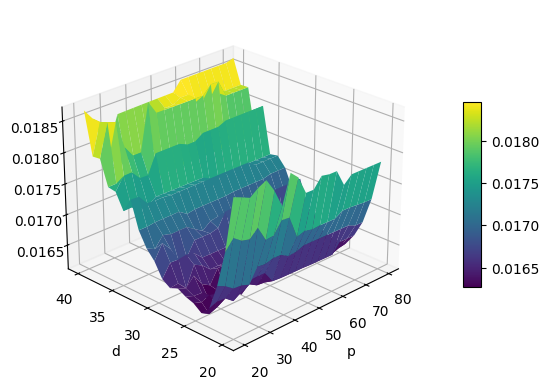

In [30]:
  # Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(P, D, Z, cmap='viridis')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)  # Add a colorbar

ax.set_xlabel('p')
ax.set_ylabel('d')
# Set the view angle
ax.view_init(elev=25, azim=225)  # Adjust these values as needed
plt.savefig("obj.svg")
plt.show()

In [12]:
!jupyter nbextension enable --py widgetsnbextension --sys-prefix

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate run troubleshoot

Jupyter command `jupyter-nbextension` not found.
